In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score
import os

USE_ONLY_ONE_GPU = True
if USE_ONLY_ONE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 0 or 1

import sys
import numpy as np
import haiku as hk
import jax
import optax

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[cuda(id=0)]

In [3]:
from evoscaper.model.vae import sample_z, VAE_fn
from evoscaper.model.shared import get_activation_fn
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.math import bin_to_nearest_edge, arrayise
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import make_saves
from evoscaper.utils.normalise import make_chain_f
from evoscaper.utils.dataclasses import NormalizationSettings
from evoscaper.utils.dataset import balance_dataset, balance_dataset2d, reduce_repeat_samples

## Load data

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_csv(fn)
len(data)

600000

In [5]:
data['adaptability'] = calculate_adaptation(
    s=data['sensitivity_wrt_species-6'].values, 
    p=data['precision_wrt_species-6'].values)
data['Log sensitivity'] = np.log10(data['sensitivity_wrt_species-6'])

## Hyperparameters

In [6]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
USE_SIGMOID_DECODER = False
HIDDEN_SIZE = 32
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 2
NUM_DEC_LAYERS = 2
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 
ENC_INIT = 'HeNormal'
DEC_INIT = 'HeNormal'
ACTIVATION = 'leaky_relu'

# Dataset 
OBJECTIVE_COL = 'Log sensitivity'  # 'adaptability'  # sensitivity_wrt_species-6
# OBJECTIVE_COL = 'sensitivity_wrt_species-6'
include_diffs = False
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_2']

# Dataset training
BATCH_SIZE = 128
FILT_X_NANS = True
FILT_Y_NANS = True
FILT_SENSITIVITY_NANS = True
FILT_PRECISION_NANS = True
FILT_N_SAME_X_MAX = 1
FILT_N_SAME_X_MAX_BINS = 15
PREP_X_STANDARDISE = False
PREP_Y_STANDARDISE = False
PREP_X_MINMAX = True
PREP_Y_MINMAX = True
PREP_X_ROBUST_SCALING = True
PREP_Y_ROBUST_SCALING = True
PREP_X_LOGSCALE = False
PREP_Y_LOGSCALE = False
PREP_X_CATEGORICAL = False
PREP_Y_CATEGORICAL = True
PREP_X_CATEGORICAL_ONEHOT = False
PREP_Y_CATEGORICAL_ONEHOT = True
PREP_X_CATEGORICAL_NBINS = 10
PREP_Y_CATEGORICAL_NBINS = 10
PREP_X_CATEGORICAL_METHOD = 'quantile'
PREP_Y_CATEGORICAL_METHOD = 'quantile'
PREP_X_NEG = True
PREP_Y_NEG = False
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)

# Training
EPOCHS = 1000
LEARNING_RATE = 1e-1
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_KL_DIV = True
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 50
KL_WEIGHT = 2.5e-2  # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
DROPOUT_RATE = 0.1

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG, use_kl_div=USE_KL_DIV, kl_weight=KL_WEIGHT) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_KLw25e2'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



# Initialise

## Init data

In [7]:
filt = data['sample_name'].isin(OUTPUT_SPECIES) & ~data['precision_wrt_species-6'].isna() & ~data['sensitivity_wrt_species-6'].isna(
) & (np.abs(data['precision_wrt_species-6']) < np.inf) & data[OBJECTIVE_COL].notna() & (np.abs(data[OBJECTIVE_COL]) < np.inf) & (np.abs(data['sensitivity_wrt_species-6']) < np.inf)

# Balance the dataset
df = data[filt]
# df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
#     data, X_TYPE, remove_symmetrical=True), n=100)
df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))

df = df.reset_index(drop=True)

/tmp/ipykernel_1155778/1054573860.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[772.4 784.  775.1 ... 724.3 722.3 683. ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))


### Subsample overrepresented points

Text(0.5, 1.0, 'Energies mean')

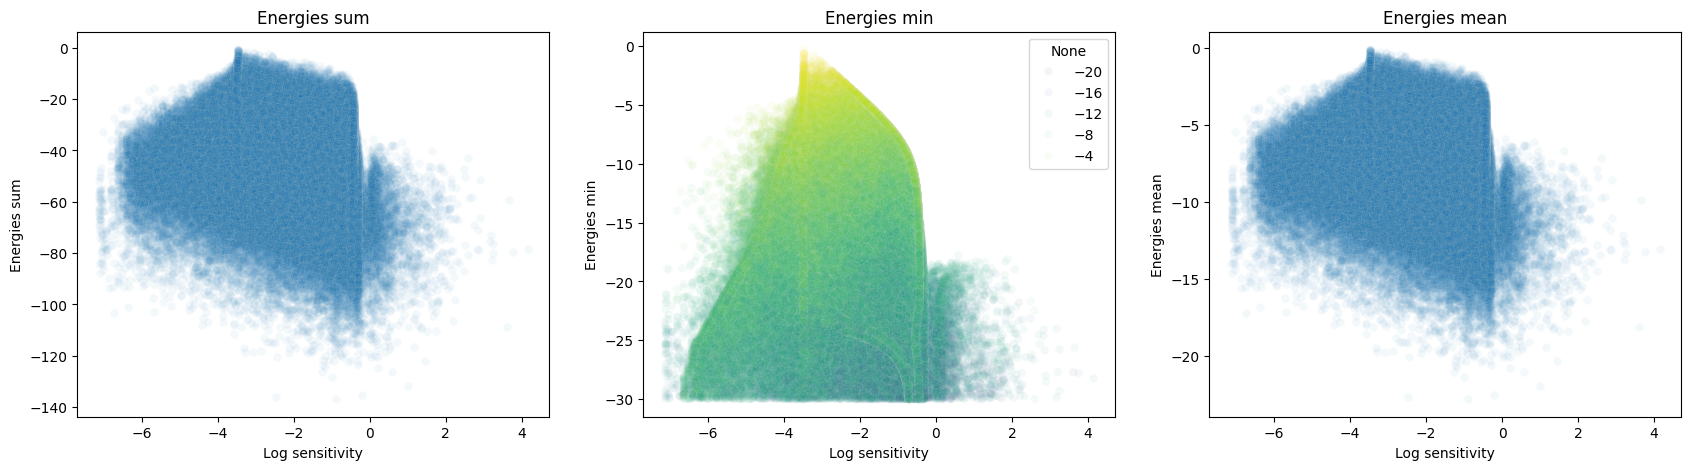

In [8]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].sum(axis=1), alpha=0.05)
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies sum')
plt.title('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].min(axis=1), alpha=0.05,
                hue=df[X_COLS].mean(axis=1), palette='viridis')
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies min')
plt.title('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].mean(axis=1), alpha=0.05)
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies mean')
plt.title('Energies mean')

### Reduce circuits that are overrepresented

In [9]:
# df = df.reset_index(drop=True)

# agg_func = lambda x: tuple(x)

# df.loc[:, X_COLS] = df[X_COLS].apply(lambda x: np.round(x, 1))
# df_bal = balance_dataset(PRNG, df, cols=X_COLS, nbin=nbin, 
#                          bin_max=n_same_circ_max, use_log=False, func1=agg_func)
# # df_bal = df
# df_bal = df_bal.reset_index(drop=True)
df_bal = reduce_repeat_samples(df, X_COLS, n_same_circ_max=FILT_N_SAME_X_MAX, nbin=FILT_N_SAME_X_MAX_BINS)


Text(0.5, 1.0, 'Sensitivity after balancing')

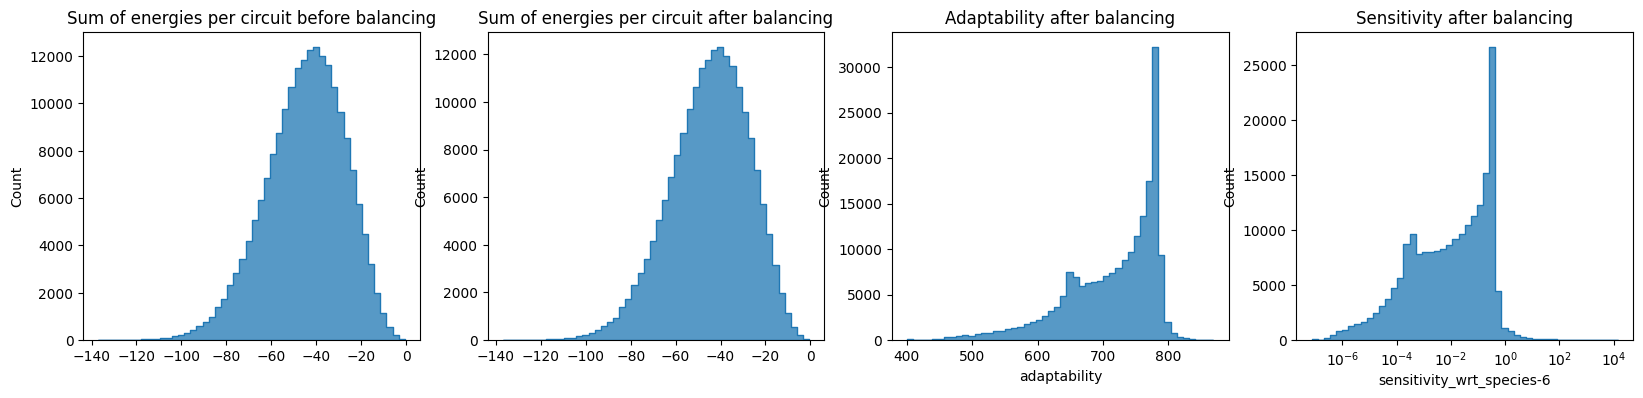

In [10]:
fig = plt.figure(figsize=(5*4, 4))
ax = plt.subplot(1,4,1)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,4,3)
sns.histplot(df_bal, x='adaptability', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability after balancing')
ax = plt.subplot(1,4,4)
sns.histplot(df_bal, x='sensitivity_wrt_species-6', bins=50, log_scale=[True, False], element='step')
plt.title('Sensitivity after balancing')


Text(0.5, 0.98, 'Energies of species in a peak adaptability range')

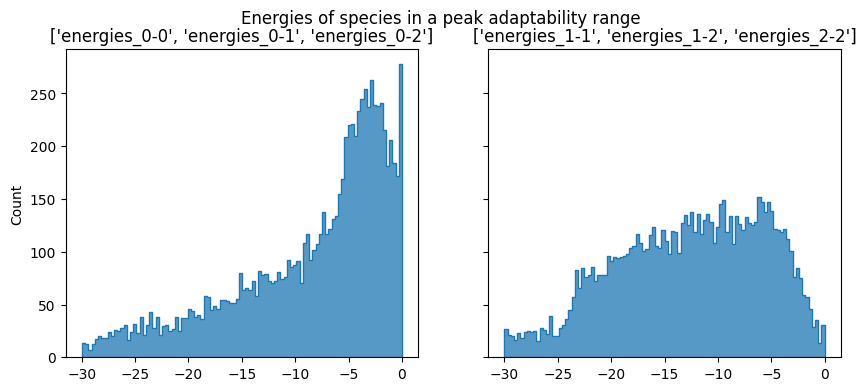

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[:3]].min(axis=1), bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(X_COLS[:3])
sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[3:]].min(axis=1), bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(X_COLS[3:])
plt.suptitle('Energies of species in a peak adaptability range')

### Reduce the number of null circuits

In [12]:
# n_null_max = 100
# idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

# df_bal2 = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


# fig = plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
# plt.title('Before')
# plt.xlabel('Sum of interactions')
# ax = plt.subplot(1,2,2)
# plt.title('After')
# plt.xlabel('Sum of interactions')
# sns.histplot(df_bal2[X_COLS].sum(axis=1), bins=50, element='step')
# plt.suptitle('Balancing null circuits')


In [13]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# # df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# fig = plt.figure(figsize=(10,4))
# ax = plt.subplot(1,2,1)
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.title('Before')

# # Need to recurse this subsampling to make it neat
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# ax = plt.subplot(1,2,2)
# plt.title('After')
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.suptitle('Balancing energies + adaptability')

Text(0.5, 0.98, 'Balance of dataset for conditioning variable Log sensitivity')

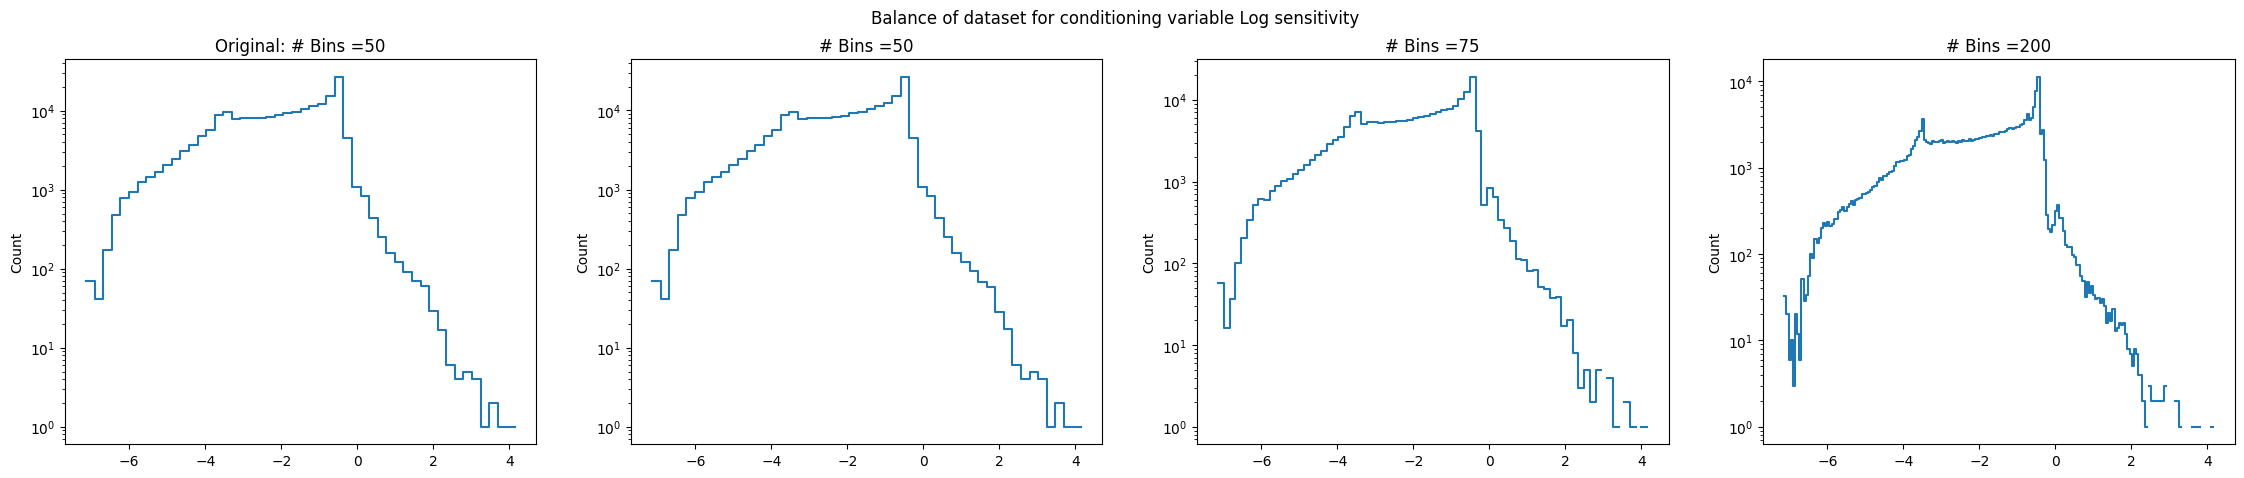

In [14]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df_bal = balance_dataset(df_bal, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df_bal = balance_dataset(df, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


In [15]:
if TOTAL_DS is None:
    TOTAL_DS = len(df_bal)
TOTAL_DS = int(np.min([TOTAL_DS, TOTAL_DS_MAX, len(df_bal)]))
TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

### Scale the input data

In [16]:
def f_reshape(i): return i.reshape(N_BATCHES, BATCH_SIZE, i.shape[-1])
def f_unreshape(i): return i.reshape(np.prod(i.shape[:-1]), i.shape[-1])


In [17]:
x = [df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS]
x = np.concatenate(x, axis=1).squeeze()
cond = df_bal[OBJECTIVE_COL].iloc[:TOTAL_DS].to_numpy()[:, None]

x_norm_settings = NormalizationSettings(
    negative=PREP_X_NEG,
    logscale=PREP_X_LOGSCALE,
    standardise=PREP_X_STANDARDISE,
    min_max=PREP_X_MINMAX,
    robust_scaling=PREP_X_ROBUST_SCALING,
    categorical=PREP_X_CATEGORICAL,
    categorical_onehot=PREP_X_CATEGORICAL_ONEHOT,
    categorical_n_bins=PREP_X_CATEGORICAL_NBINS,
    categorical_method=PREP_X_CATEGORICAL_METHOD
)
y_norm_settings = NormalizationSettings(
    negative=PREP_Y_NEG,
    logscale=PREP_Y_LOGSCALE,
    standardise=PREP_Y_STANDARDISE,
    min_max=PREP_Y_MINMAX,
    robust_scaling=PREP_Y_ROBUST_SCALING,
    categorical=PREP_Y_CATEGORICAL,
    categorical_onehot=PREP_Y_CATEGORICAL_ONEHOT,
    categorical_n_bins=PREP_Y_CATEGORICAL_NBINS,
    categorical_method=PREP_Y_CATEGORICAL_METHOD
)
x_datanormaliser, x_methods_preprocessing = make_chain_f(x_norm_settings)
y_datanormaliser, y_methods_preprocessing = make_chain_f(y_norm_settings)
    
x = x_datanormaliser.create_chain_preprocessor(x_methods_preprocessing)(x)
cond = y_datanormaliser.create_chain_preprocessor(y_methods_preprocessing)(cond)

In [18]:
N_HEAD = x.shape[-1]

PRNG, shuffle_key = jax.random.split(PRNG)
shuffled_indices = jax.random.permutation(shuffle_key, x.shape[0])
x = x[shuffled_indices]
cond = cond[shuffled_indices]

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [19]:
cond.shape, x.shape, np.concatenate([x, cond], axis=-1).shape

((198016, 10), (198016, 6), (198016, 16))

Text(0.5, 0.98, 'Dataset after balancing')

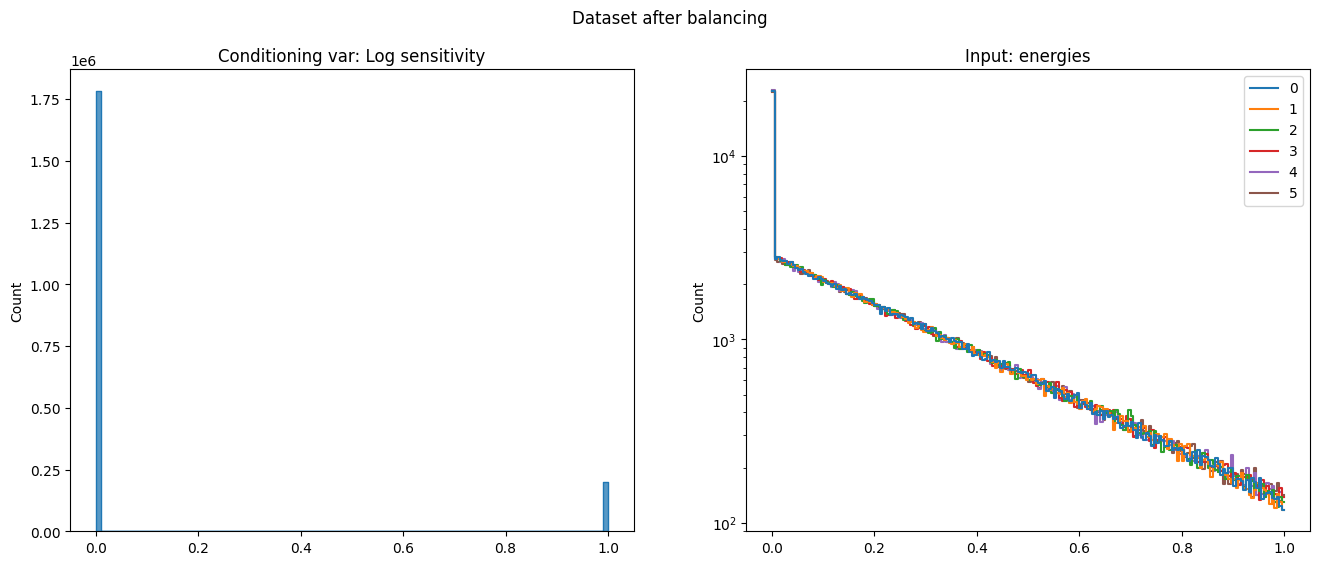

In [20]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, False], bins=100, element='step', fill=True)
plt.title(f'Conditioning var: {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [21]:
model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], 
                  #  HIDDEN_SIZE=HIDDEN_SIZE, USE_SIGMOID_DECODER=USE_SIGMOID_DECODER, enc_init='RandomNormal', dec_init='RandomNormal')
                   HIDDEN_SIZE=HIDDEN_SIZE, decoder_activation_final=jax.nn.sigmoid if USE_SIGMOID_DECODER else jax.nn.leaky_relu, 
                   enc_init=ENC_INIT, dec_init=DEC_INIT, activation=get_activation_fn(ACTIVATION), dropout_rate=DROPOUT_RATE if USE_DROPOUT else None)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
dummy_x = jax.random.normal(PRNG, x.shape)
dummy_cond = jax.random.normal(PRNG, cond.shape)
params = model_t.init(PRNG, dummy_x, dummy_cond, deterministic=False)


In [22]:
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply


In [23]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [24]:
model(params, PRNG, x, cond, return_muvar=False).shape

(198016, 6)

Text(0.5, 0.98, 'Weight init with dummy xy using HeNormal and activation leaky_relu')

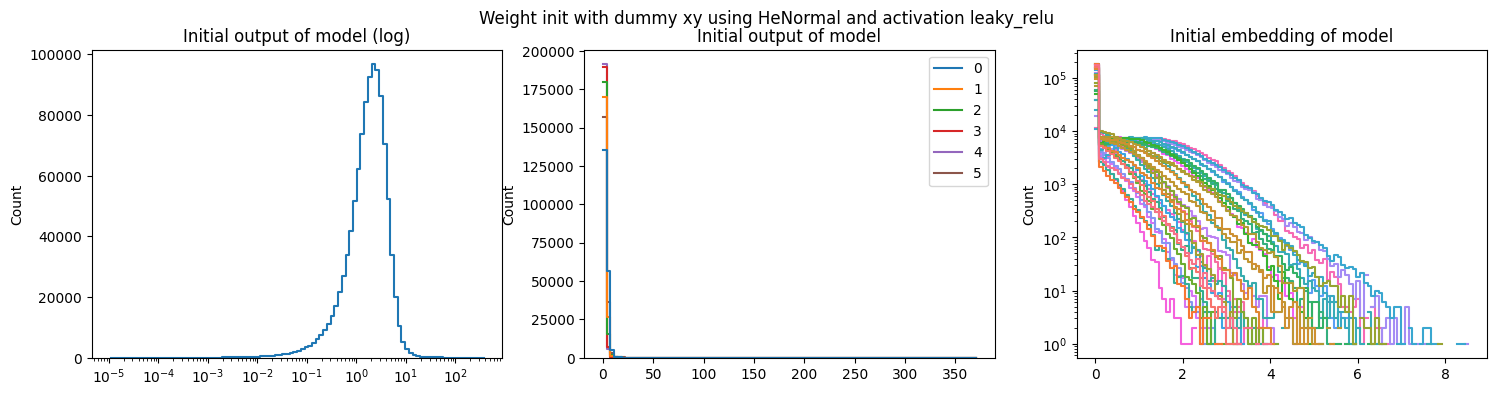

In [25]:
fig = plt.figure(figsize=(3*6, 4))
plt.subplot(1,3,1)
sns.histplot(model(params, PRNG, dummy_x, dummy_cond).flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model (log)')
plt.subplot(1,3,2)
sns.histplot(model(params, PRNG, dummy_x, dummy_cond), bins=100, log_scale=[False, False], element='step', fill=False)
# sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model')
plt.subplot(1,3,3)
sns.histplot(encoder(params, PRNG, np.concatenate([dummy_x, dummy_cond], axis=-1)), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Initial embedding of model')
plt.suptitle(f'Weight init with dummy xy using {DEC_INIT} and activation {ACTIVATION}')

Text(0.5, 0.98, 'Weight init with actual xy using HeNormal and activation leaky_relu')

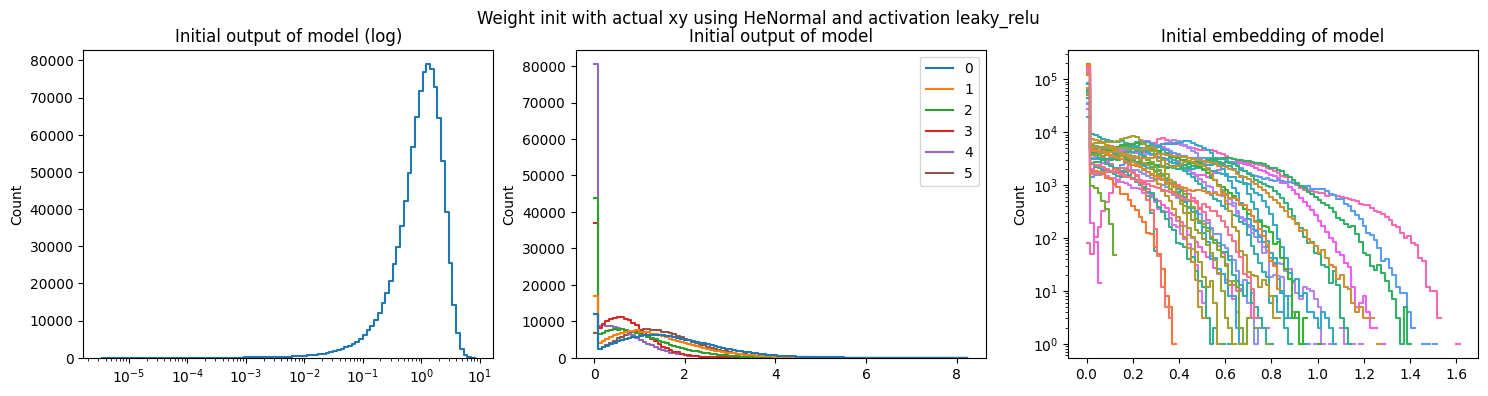

In [26]:
fig = plt.figure(figsize=(3*6, 4))
plt.subplot(1,3,1)
sns.histplot(model(params, PRNG, x, cond).flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model (log)')
plt.subplot(1,3,2)
sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[False, False], element='step', fill=False)
# sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model')
plt.subplot(1,3,3)
sns.histplot(encoder(params, PRNG, np.concatenate([x, cond], axis=-1)), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Initial embedding of model')
plt.suptitle(f'Weight init with actual xy using {DEC_INIT} and activation {ACTIVATION}')

In [27]:
# Potential diagnostic code
def print_layer_stats(model):
    for name, module in model.items():
        if 'w' in module:
            print(f"Layer {name}:")
            print(f"  Weight mean: {module['w'].mean().item()}")
            print(f"  Weight std: {module['w'].std().item()}")

print_layer_stats(params)

Layer encoder/~create_layers/linear_0:
  Weight mean: 0.0015164094511419535
  Weight std: 0.3538583815097809
Layer encoder/~create_layers/linear_1:
  Weight mean: 7.848080713301897e-05


  Weight std: 0.17494861781597137
Layer encoder/~create_layers/linear_2:
  Weight mean: 0.0030521354638040066
  Weight std: 0.17092104256153107
Layer cvae/~/h2mu:
  Weight mean: 0.003116301726549864


  Weight std: 0.1506325602531433
Layer cvae/~/h2logvar:
  Weight mean: 0.0034047705121338367
  Weight std: 0.156779944896698
Layer decoder/~create_layers/linear_0:
  Weight mean: 0.005962614435702562
  Weight std: 0.21699859201908112
Layer decoder/~create_layers/linear_1:
  Weight mean: 0.0015682075172662735


  Weight std: 0.2497914880514145
Layer decoder/~create_layers/linear_2:
  Weight mean: -0.004245966672897339
  Weight std: 0.17674040794372559
Layer decoder/~create_layers/linear_3:
  Weight mean: 0.014803430065512657
  Weight std: 0.17802858352661133


## Init optimiser

In [28]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [29]:
x = f_reshape(x)
y = f_reshape(x)
cond = f_reshape(cond)


x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

x_train.shape

(1237, 128, 6)

In [30]:
np.prod(x_train.shape[:2]), np.prod(x_val.shape[:2])


(np.int64(158336), np.int64(39680))

In [31]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    # (params, optimiser_state), (train_loss, grads) = f((params, optimiser_state), (x_batch, y_batch, cond_batch))
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

Text(0.5, 1.0, 'Preprocessing of conditional data')

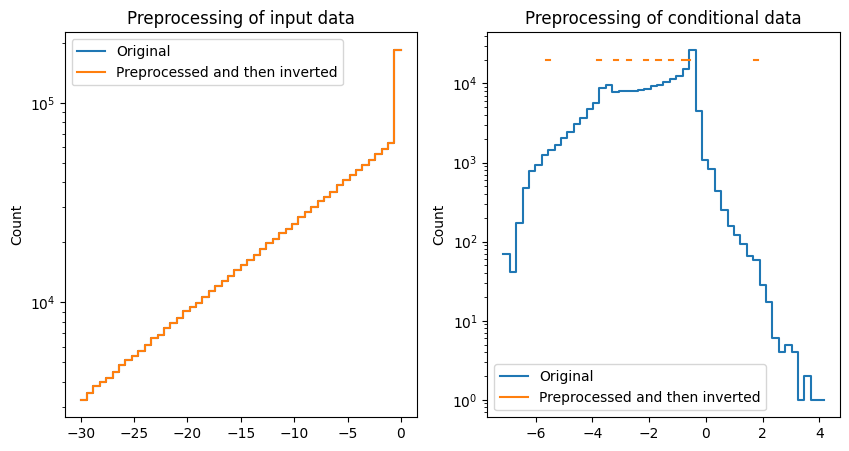

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.histplot(np.concatenate([df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of input data')

plt.subplot(1,2,2)
sns.histplot(df_bal[OBJECTIVE_COL].iloc[:TOTAL_DS].values.flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of conditional data')


## Run train

In [33]:
tstart = datetime.now()
params, saves = train(params, PRNG, model,
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

print(datetime.now() - tstart)

Epoch 0 / 1000 -		 Train loss: 0.3006596565246582	Val loss: 0.13792185485363007	Val accuracy: 0.07819640636444092


Epoch 20 / 1000 -		 Train loss: 0.042769018560647964	Val loss: 0.12948210537433624	Val accuracy: 0.022568045184016228


Epoch 40 / 1000 -		 Train loss: 0.024409735575318336	Val loss: 0.45853859186172485	Val accuracy: 0.04745883867144585


Epoch 60 / 1000 -		 Train loss: 0.019429786130785942	Val loss: 0.91832435131073	Val accuracy: 0.04945816472172737


Epoch 80 / 1000 -		 Train loss: 0.01769000105559826	Val loss: 1.2379295825958252	Val accuracy: 0.049663979560136795


Epoch 100 / 1000 -		 Train loss: 0.01683688350021839	Val loss: 1.4617269039154053	Val accuracy: 0.04918934777379036


Epoch 120 / 1000 -		 Train loss: 0.016316058114171028	Val loss: 1.6110278367996216	Val accuracy: 0.049294356256723404


Epoch 140 / 1000 -		 Train loss: 0.015832291916012764	Val loss: 1.7442796230316162	Val accuracy: 0.04974798485636711


Epoch 160 / 1000 -		 Train loss: 0.01555312518030405	Val loss: 1.868064284324646	Val accuracy: 0.04939096048474312


Epoch 180 / 1000 -		 Train loss: 0.015263439156115055	Val loss: 1.9645779132843018	Val accuracy: 0.049403563141822815


Epoch 200 / 1000 -		 Train loss: 0.015049789100885391	Val loss: 2.0998504161834717	Val accuracy: 0.04973538592457771


Epoch 220 / 1000 -		 Train loss: 0.01485325489193201	Val loss: 2.2243614196777344	Val accuracy: 0.049474965780973434


Epoch 240 / 1000 -		 Train loss: 0.014669138938188553	Val loss: 2.2816877365112305	Val accuracy: 0.04941616207361221


Epoch 260 / 1000 -		 Train loss: 0.014502082020044327	Val loss: 2.3822174072265625	Val accuracy: 0.04969758167862892


Epoch 280 / 1000 -		 Train loss: 0.0143534941598773	Val loss: 2.5092413425445557	Val accuracy: 0.04909694194793701


Epoch 300 / 1000 -		 Train loss: 0.014178282581269741	Val loss: 2.545001983642578	Val accuracy: 0.049525368958711624


Epoch 320 / 1000 -		 Train loss: 0.014026552438735962	Val loss: 2.676234483718872	Val accuracy: 0.049193549901247025


Epoch 340 / 1000 -		 Train loss: 0.013868376612663269	Val loss: 2.740530252456665	Val accuracy: 0.049483366310596466


Epoch 360 / 1000 -		 Train loss: 0.013714147731661797	Val loss: 2.875725030899048	Val accuracy: 0.04918514937162399


Epoch 380 / 1000 -		 Train loss: 0.01356997899711132	Val loss: 2.9635369777679443	Val accuracy: 0.049264952540397644


Epoch 400 / 1000 -		 Train loss: 0.013477337546646595	Val loss: 3.093937397003174	Val accuracy: 0.0491473451256752


Epoch 420 / 1000 -		 Train loss: 0.013334735296666622	Val loss: 3.2276623249053955	Val accuracy: 0.048991937190294266


Epoch 440 / 1000 -		 Train loss: 0.013177173212170601	Val loss: 3.3837804794311523	Val accuracy: 0.04871471971273422


Epoch 460 / 1000 -		 Train loss: 0.01309874840080738	Val loss: 3.496753692626953	Val accuracy: 0.04897933453321457


Epoch 480 / 1000 -		 Train loss: 0.01296788640320301	Val loss: 3.6196067333221436	Val accuracy: 0.04888692870736122


Epoch 500 / 1000 -		 Train loss: 0.012858634814620018	Val loss: 3.7863125801086426	Val accuracy: 0.04889532923698425


Epoch 520 / 1000 -		 Train loss: 0.012741333805024624	Val loss: 3.9871814250946045	Val accuracy: 0.048655916005373


Epoch 540 / 1000 -		 Train loss: 0.012620747089385986	Val loss: 4.21022891998291	Val accuracy: 0.04875672236084938


Epoch 560 / 1000 -		 Train loss: 0.01251108106225729	Val loss: 4.36220121383667	Val accuracy: 0.048773523420095444


Epoch 580 / 1000 -		 Train loss: 0.012428791262209415	Val loss: 4.649034023284912	Val accuracy: 0.04857610911130905


Epoch 600 / 1000 -		 Train loss: 0.012286227196455002	Val loss: 4.894315719604492	Val accuracy: 0.04857610911130905


Epoch 620 / 1000 -		 Train loss: 0.012182658538222313	Val loss: 5.077053070068359	Val accuracy: 0.04863911494612694


Epoch 640 / 1000 -		 Train loss: 0.012053539976477623	Val loss: 5.362289905548096	Val accuracy: 0.0484963059425354


Epoch 660 / 1000 -		 Train loss: 0.011917855590581894	Val loss: 5.6644392013549805	Val accuracy: 0.048433300107717514


Epoch 680 / 1000 -		 Train loss: 0.011843347921967506	Val loss: 6.042151927947998	Val accuracy: 0.04836609587073326


Epoch 700 / 1000 -		 Train loss: 0.011770447716116905	Val loss: 6.396261215209961	Val accuracy: 0.048382896929979324


Epoch 720 / 1000 -		 Train loss: 0.01164983119815588	Val loss: 6.770679473876953	Val accuracy: 0.048261091113090515


Epoch 740 / 1000 -		 Train loss: 0.01155913807451725	Val loss: 7.157315254211426	Val accuracy: 0.048160284757614136


Epoch 760 / 1000 -		 Train loss: 0.011456063017249107	Val loss: 7.58748197555542	Val accuracy: 0.0480174757540226


Epoch 780 / 1000 -		 Train loss: 0.011411881074309349	Val loss: 8.005494117736816	Val accuracy: 0.04779485985636711


Epoch 800 / 1000 -		 Train loss: 0.011283792555332184	Val loss: 8.429468154907227	Val accuracy: 0.04770665243268013


Epoch 820 / 1000 -		 Train loss: 0.011258858256042004	Val loss: 8.861019134521484	Val accuracy: 0.047530241310596466


Epoch 840 / 1000 -		 Train loss: 0.011157807894051075	Val loss: 9.34858226776123	Val accuracy: 0.047349631786346436


Epoch 860 / 1000 -		 Train loss: 0.01110896747559309	Val loss: 9.781083106994629	Val accuracy: 0.0472068227827549


Epoch 880 / 1000 -		 Train loss: 0.01106330007314682	Val loss: 10.229308128356934	Val accuracy: 0.04712281748652458


Epoch 900 / 1000 -		 Train loss: 0.011030844412744045	Val loss: 10.618067741394043	Val accuracy: 0.04696740582585335


Epoch 920 / 1000 -		 Train loss: 0.011003421619534492	Val loss: 10.97575569152832	Val accuracy: 0.046828798949718475


Epoch 940 / 1000 -		 Train loss: 0.01098132599145174	Val loss: 11.295660018920898	Val accuracy: 0.04673219099640846


Epoch 960 / 1000 -		 Train loss: 0.010963632725179195	Val loss: 11.579997062683105	Val accuracy: 0.04657678306102753


Epoch 980 / 1000 -		 Train loss: 0.010948145762085915	Val loss: 11.829315185546875	Val accuracy: 0.04649277776479721


0:15:58.918015


# Visualise

Text(0.5, 0.98, 'Training')

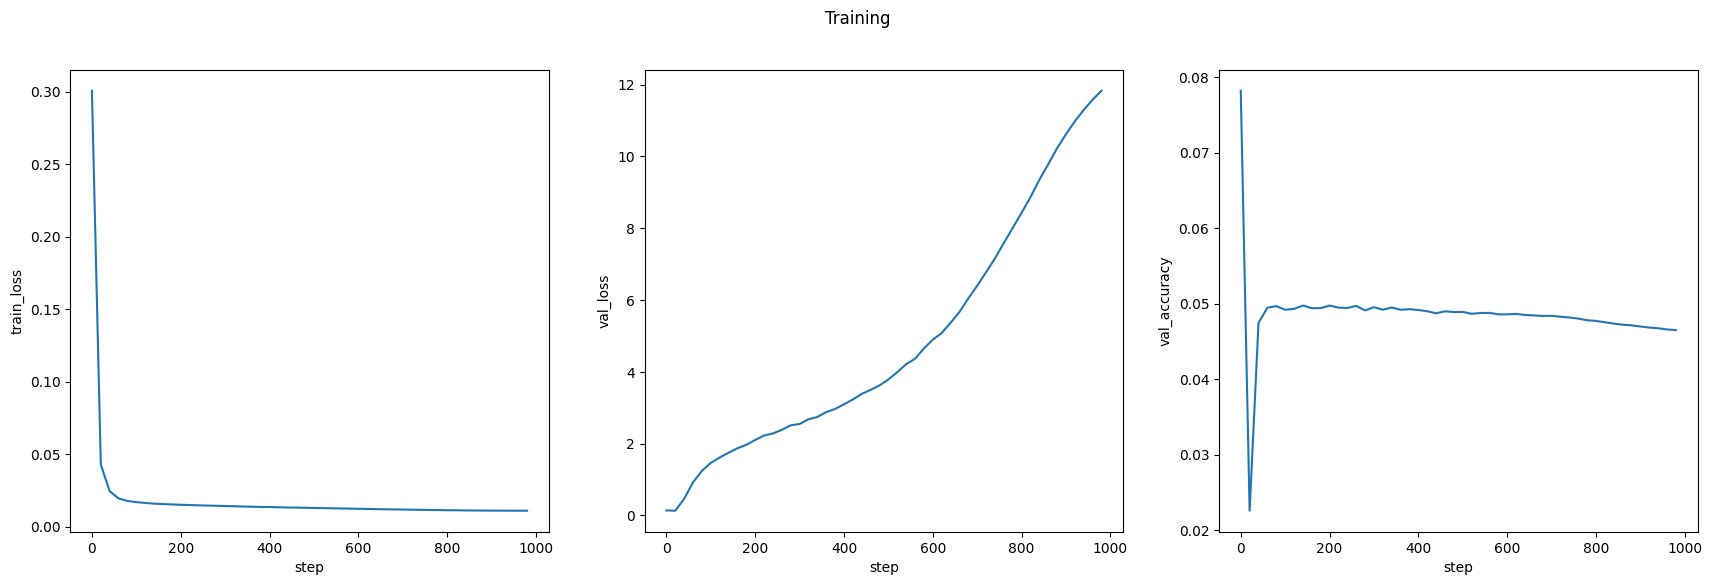

In [34]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')

In [35]:
write_json(saves, out_path=save_path)

In [36]:
print(save_path)

weight_saves/01_cvae/2024_12_17__15_38_11_saves_KLw25e2


# Examine trained model

In [37]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + relu + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + relu + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__21_21_04_saves_no_KL')  # generated from interactions + relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_17_13_saves_leaky_relu')  # generated from interactions + leaky relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_48_33_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__23_01_53_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL + encoder head hidden size
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__14_24_25_saves_new_MLP')  # generated from interactions + new MLP
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_28_08_saves_layers_1')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_51_40_saves_he_init')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_13_34_saves_he_init_KL_ls1')  # generated from interactions + only 1 layer for enc and dec + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_49_29_saves_robust_KL_e2000')  # generated from interactions + KL + robust scaling + 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__22_09_41_saves_nosigmoid_KL_new_reparam')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__23_27_37_saves_sens_brd_KL_weight')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__13_36_05_saves_sens_brd_KL_weight')  # generated from interactions + no sigmoid + new reparameterisation function + sensitivity 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_31_37_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_45_23_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3 + KL + 3 layers instead of 1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_00_32_saves_onehot')  # generated from interactions + log sensitivity + energies + onehot
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_46_49_saves_onehot_lr1e1')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_53_31_saves_onehot_nominmax')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + no minmax just robust scaling
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__18_20_05_saves_onehot_minmax_epochs10k')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__21_59_51_saves_onehot_quantile')  # generated from interactions + log sensitivity + onehot + quantile categorical + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__11_39_29_saves_log_sens_sigmoid_nocat')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + 10k epochs + minmax + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__14_22_59_saves_winit_glorot')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + sigmoid + minmax + glorot init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__15_17_29_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__17_54_40_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_12__16_17_49_saves_Eneg_henorm_nosigm_nocat')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_13__10_59_59_saves_Eneg_onehot')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_08_07_saves_Eneg_onehot_ls3')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 64
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_36_21_saves_Eneg_onehot_ls3_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__13_19_13_saves_Eneg_onehot_ls2_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(1547, 128, 6)

Text(0.5, 0.98, 'Training')

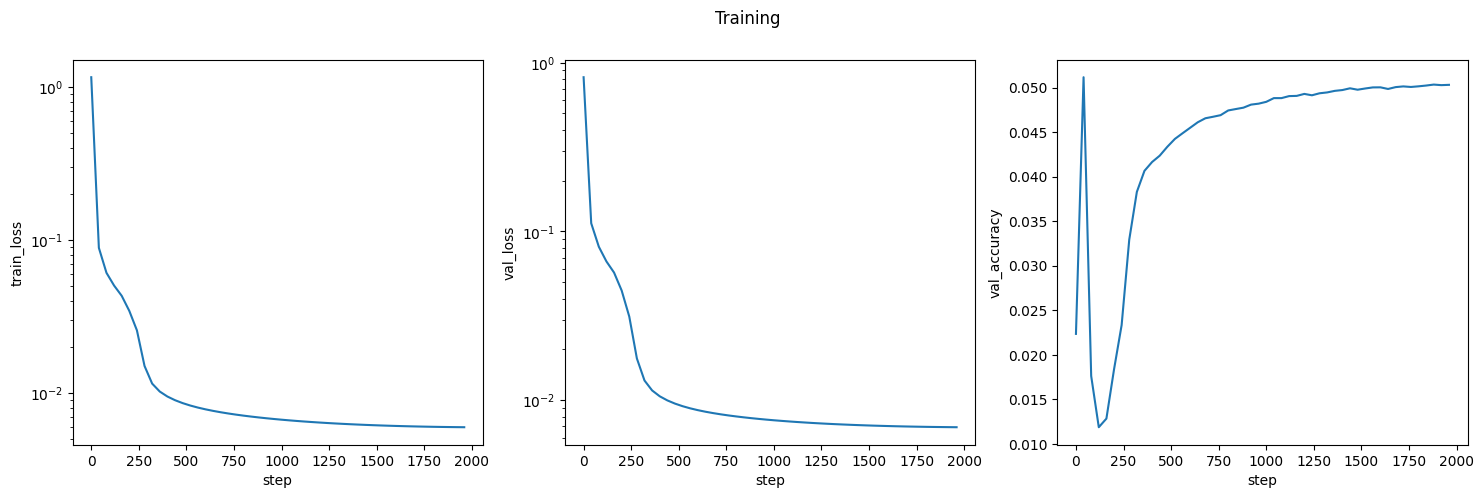

In [38]:
plt.figure(figsize=(6*3, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')
plt.suptitle('Training')

The R2 score is  0.9483036398887634
The R2 score with weighted variance is  0.9483036398887634


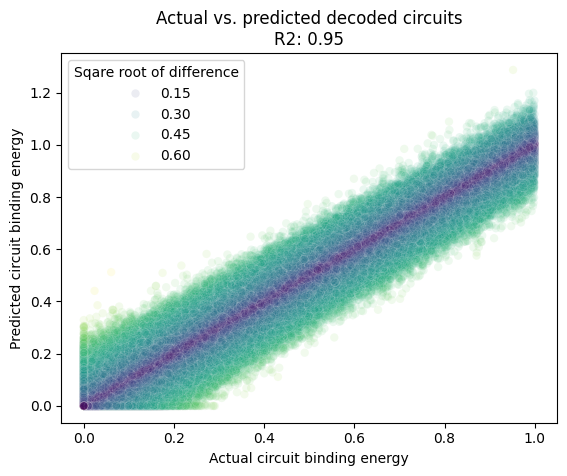

In [39]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits\nR2: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [40]:
n_to_sample = 10000

sampled_cond = np.interp(jax.random.normal(PRNG, (n_to_sample, cond.shape[-1])), [0, 1], [cond.min(), cond.max()])
sampled_h = np.random.rand(n_to_sample, ENC_LS)
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 0.5
# mu = h2mu(p, PRNG, sampled_h) 
# logvar = h2logvar(p, PRNG, sampled_h)
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 10)

Text(0.5, 1.0, 'Generated fake circuits')

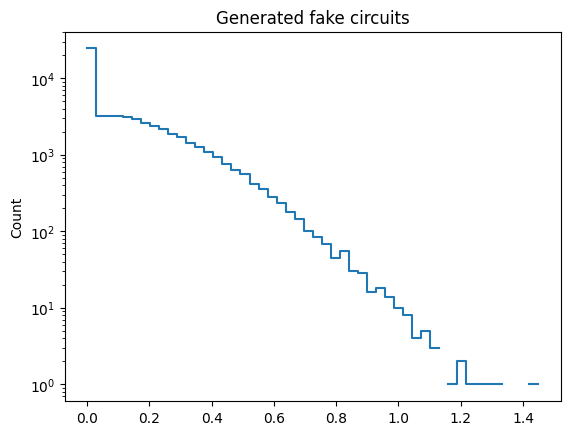

In [41]:
sns.histplot(fake_circuits.flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Generated fake circuits')

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

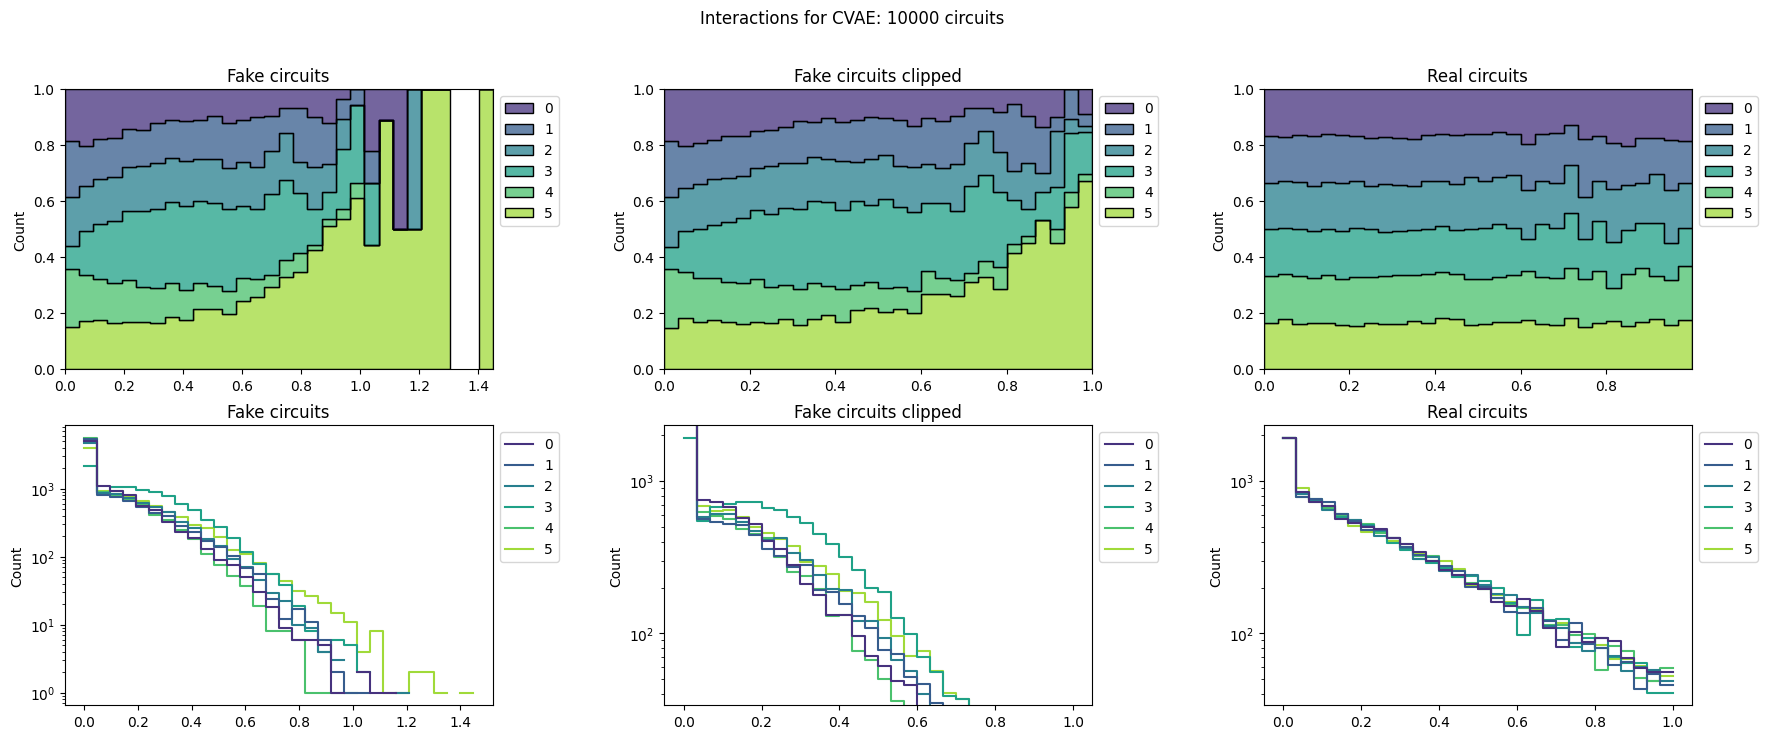

In [42]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

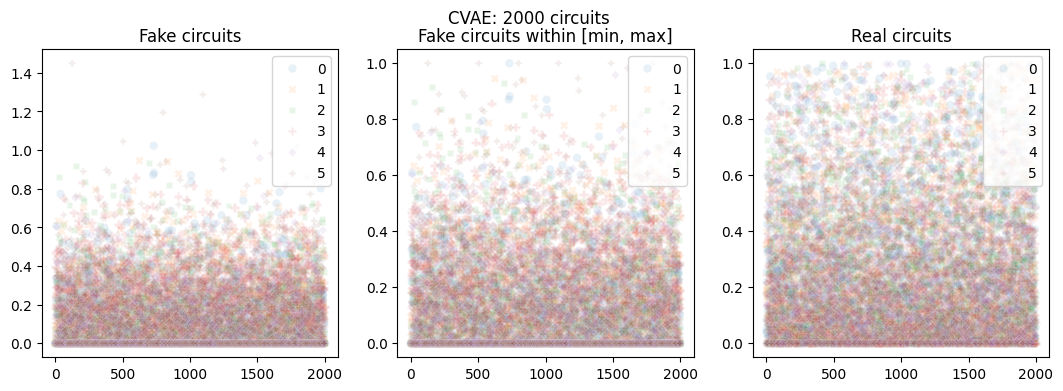

In [43]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [44]:
n_categories = 5 if not PREP_Y_CATEGORICAL_ONEHOT else PREP_Y_CATEGORICAL_NBINS
n_to_sample = 10000

if PREP_Y_CATEGORICAL_ONEHOT:
    sampled_cond = np.repeat(np.arange(PREP_Y_CATEGORICAL_NBINS)[:, None], repeats=n_to_sample, axis=1)
    sampled_cond = jax.nn.one_hot(sampled_cond, PREP_Y_CATEGORICAL_NBINS)
else:
    sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

fake_circuits.shape, sampled_cond.shape

((10, 10000, 6), (10, 10000, 10))

Text(0.5, 1.0, 'Fake circuits params')

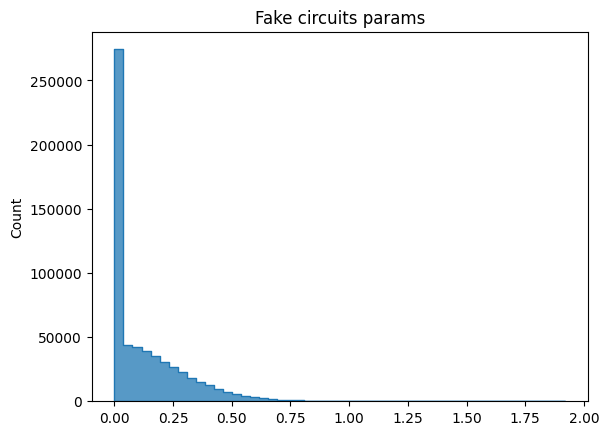

In [45]:
# sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
sns.histplot(fake_circuits.flatten(), bins=50, element='step')
plt.title('Fake circuits params')

In [46]:
len(z)

10

Text(0.5, 0.98, 'CVAE: fake circuits')

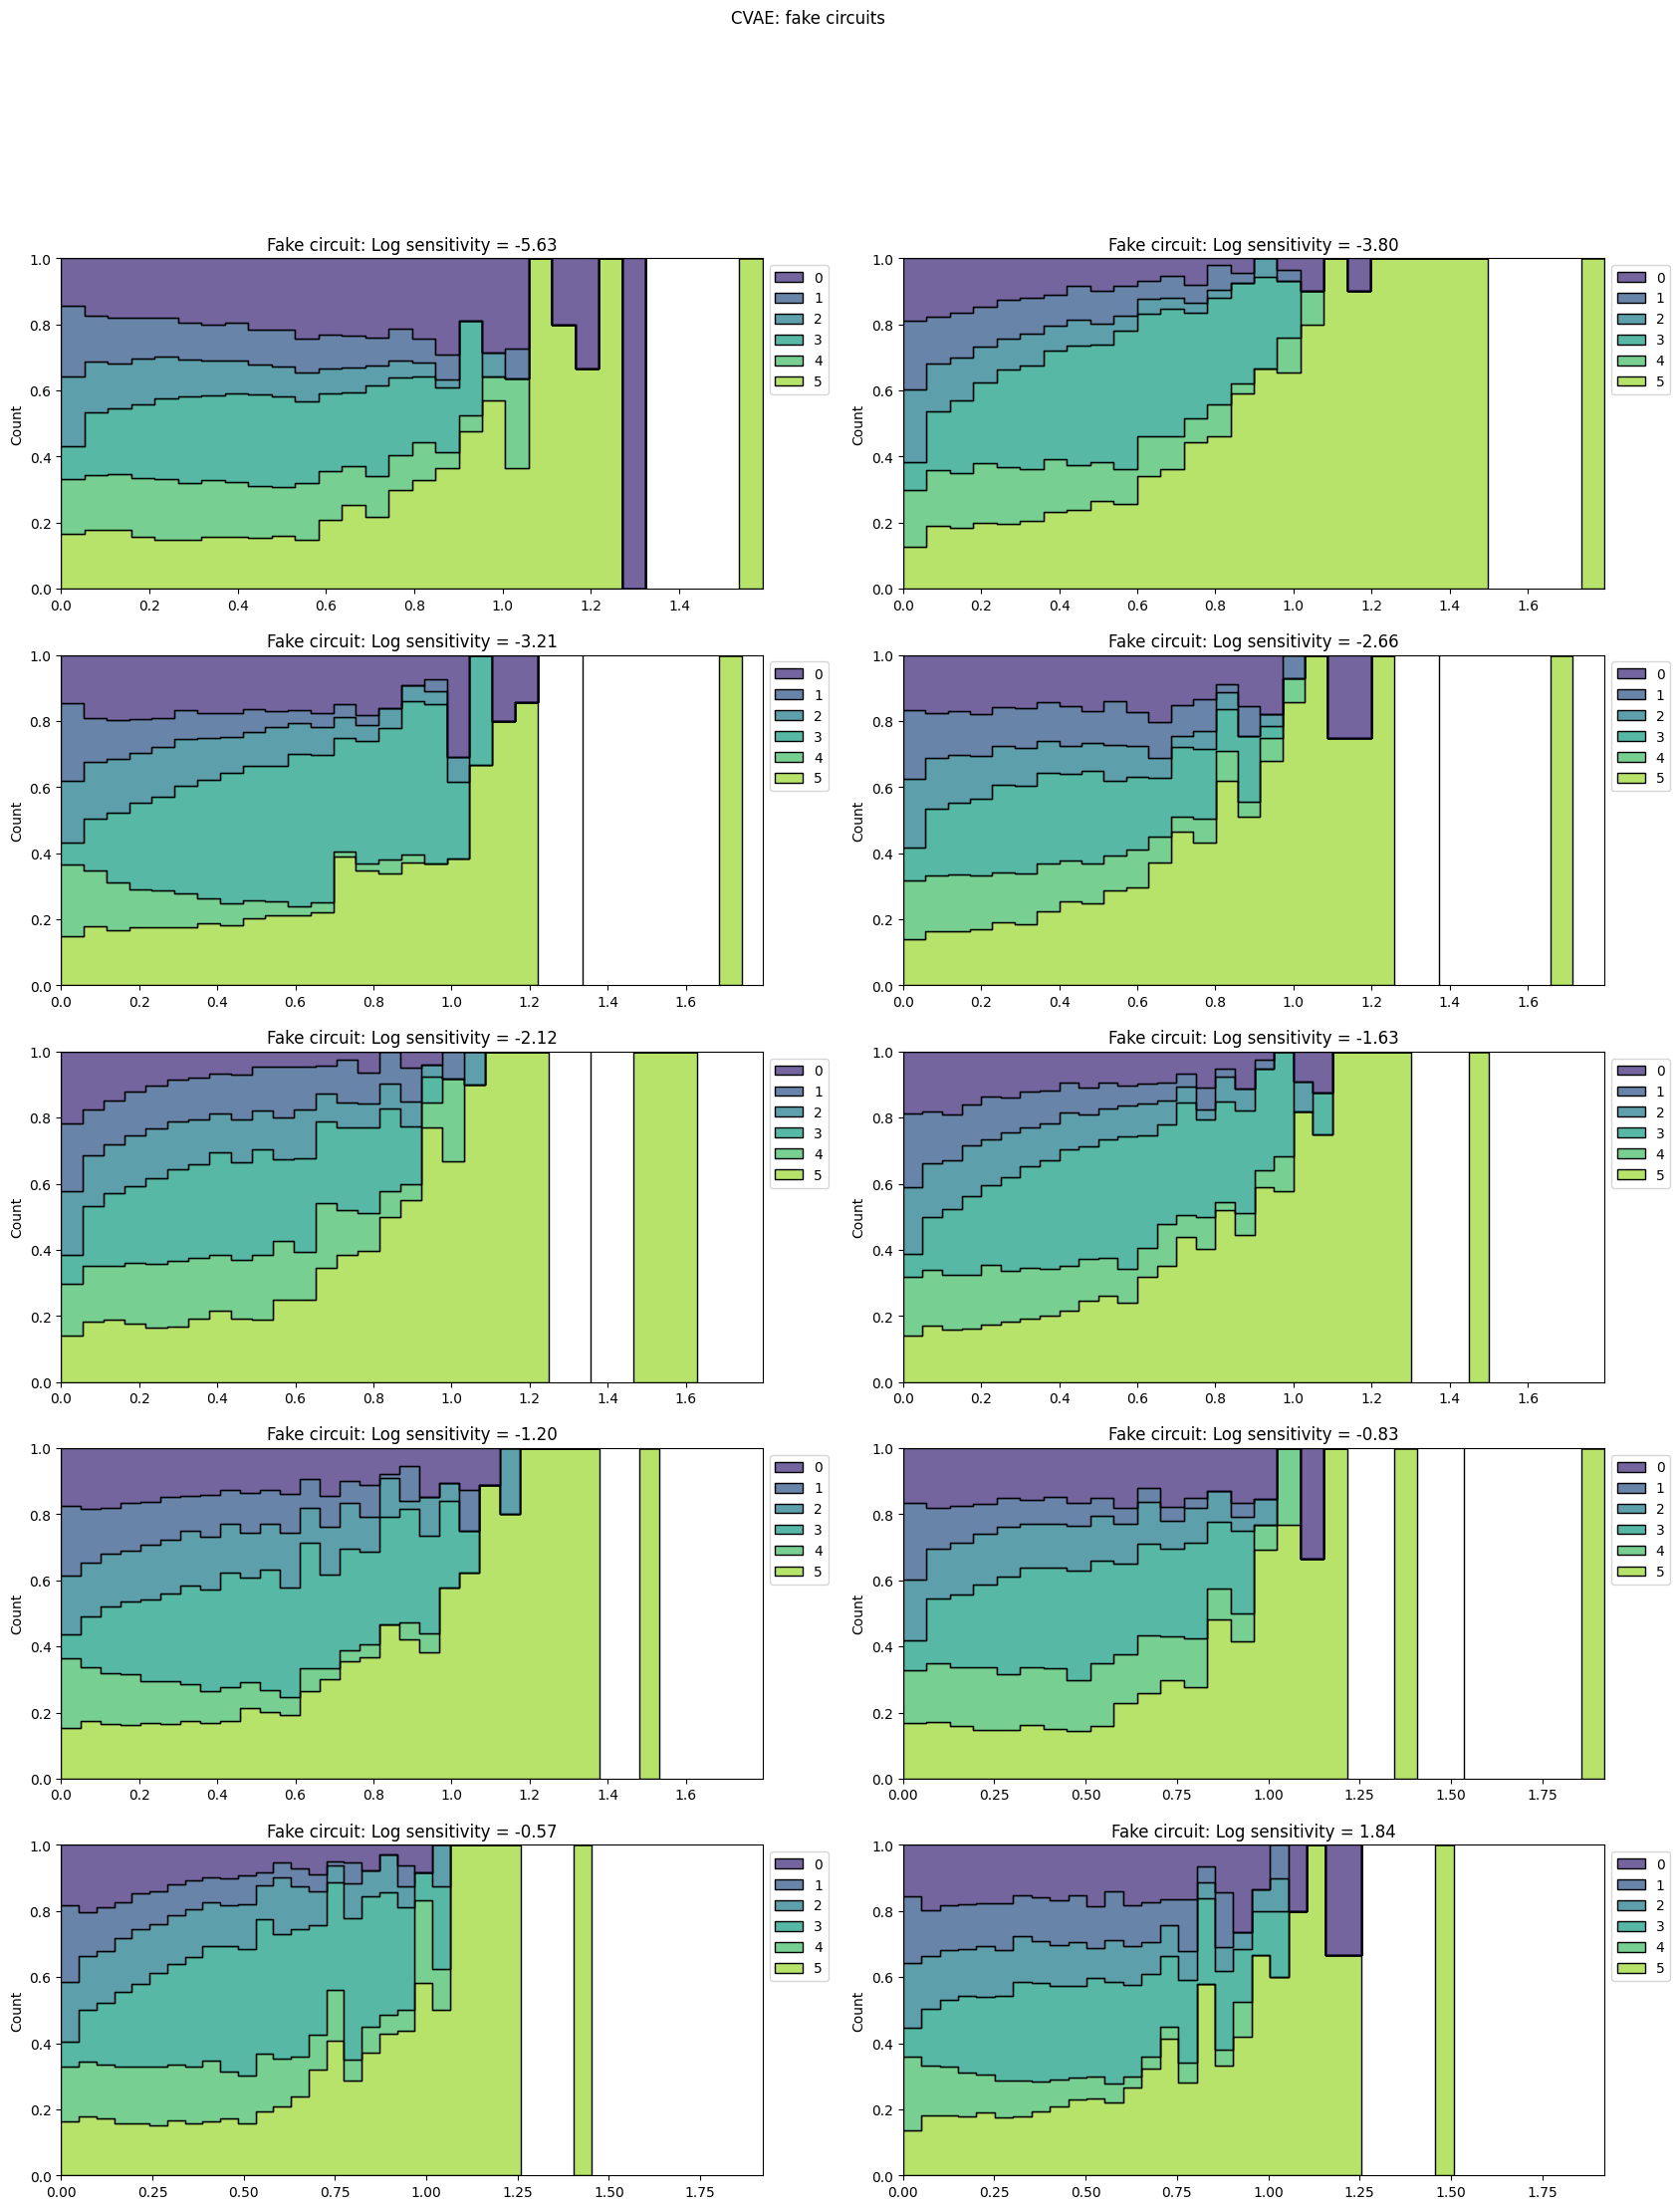

In [47]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'Fake circuit: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

## Compare to real circuit's objective

In [48]:
def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
# y_obj_all = df[OBJECTIVE_COL].to_numpy()
# for y_scale in y_scaling:
#     y_obj_all = y_scale(y_obj_all)
# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(y_obj_all, n_bins=n_categories)
df = df[~df[OBJECTIVE_COL].isna()]
df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(df[OBJECTIVE_COL].to_numpy(), n_bins=n_categories)
fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [49]:
# fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

Text(0.5, 0.98, 'CVAE: real circuits')

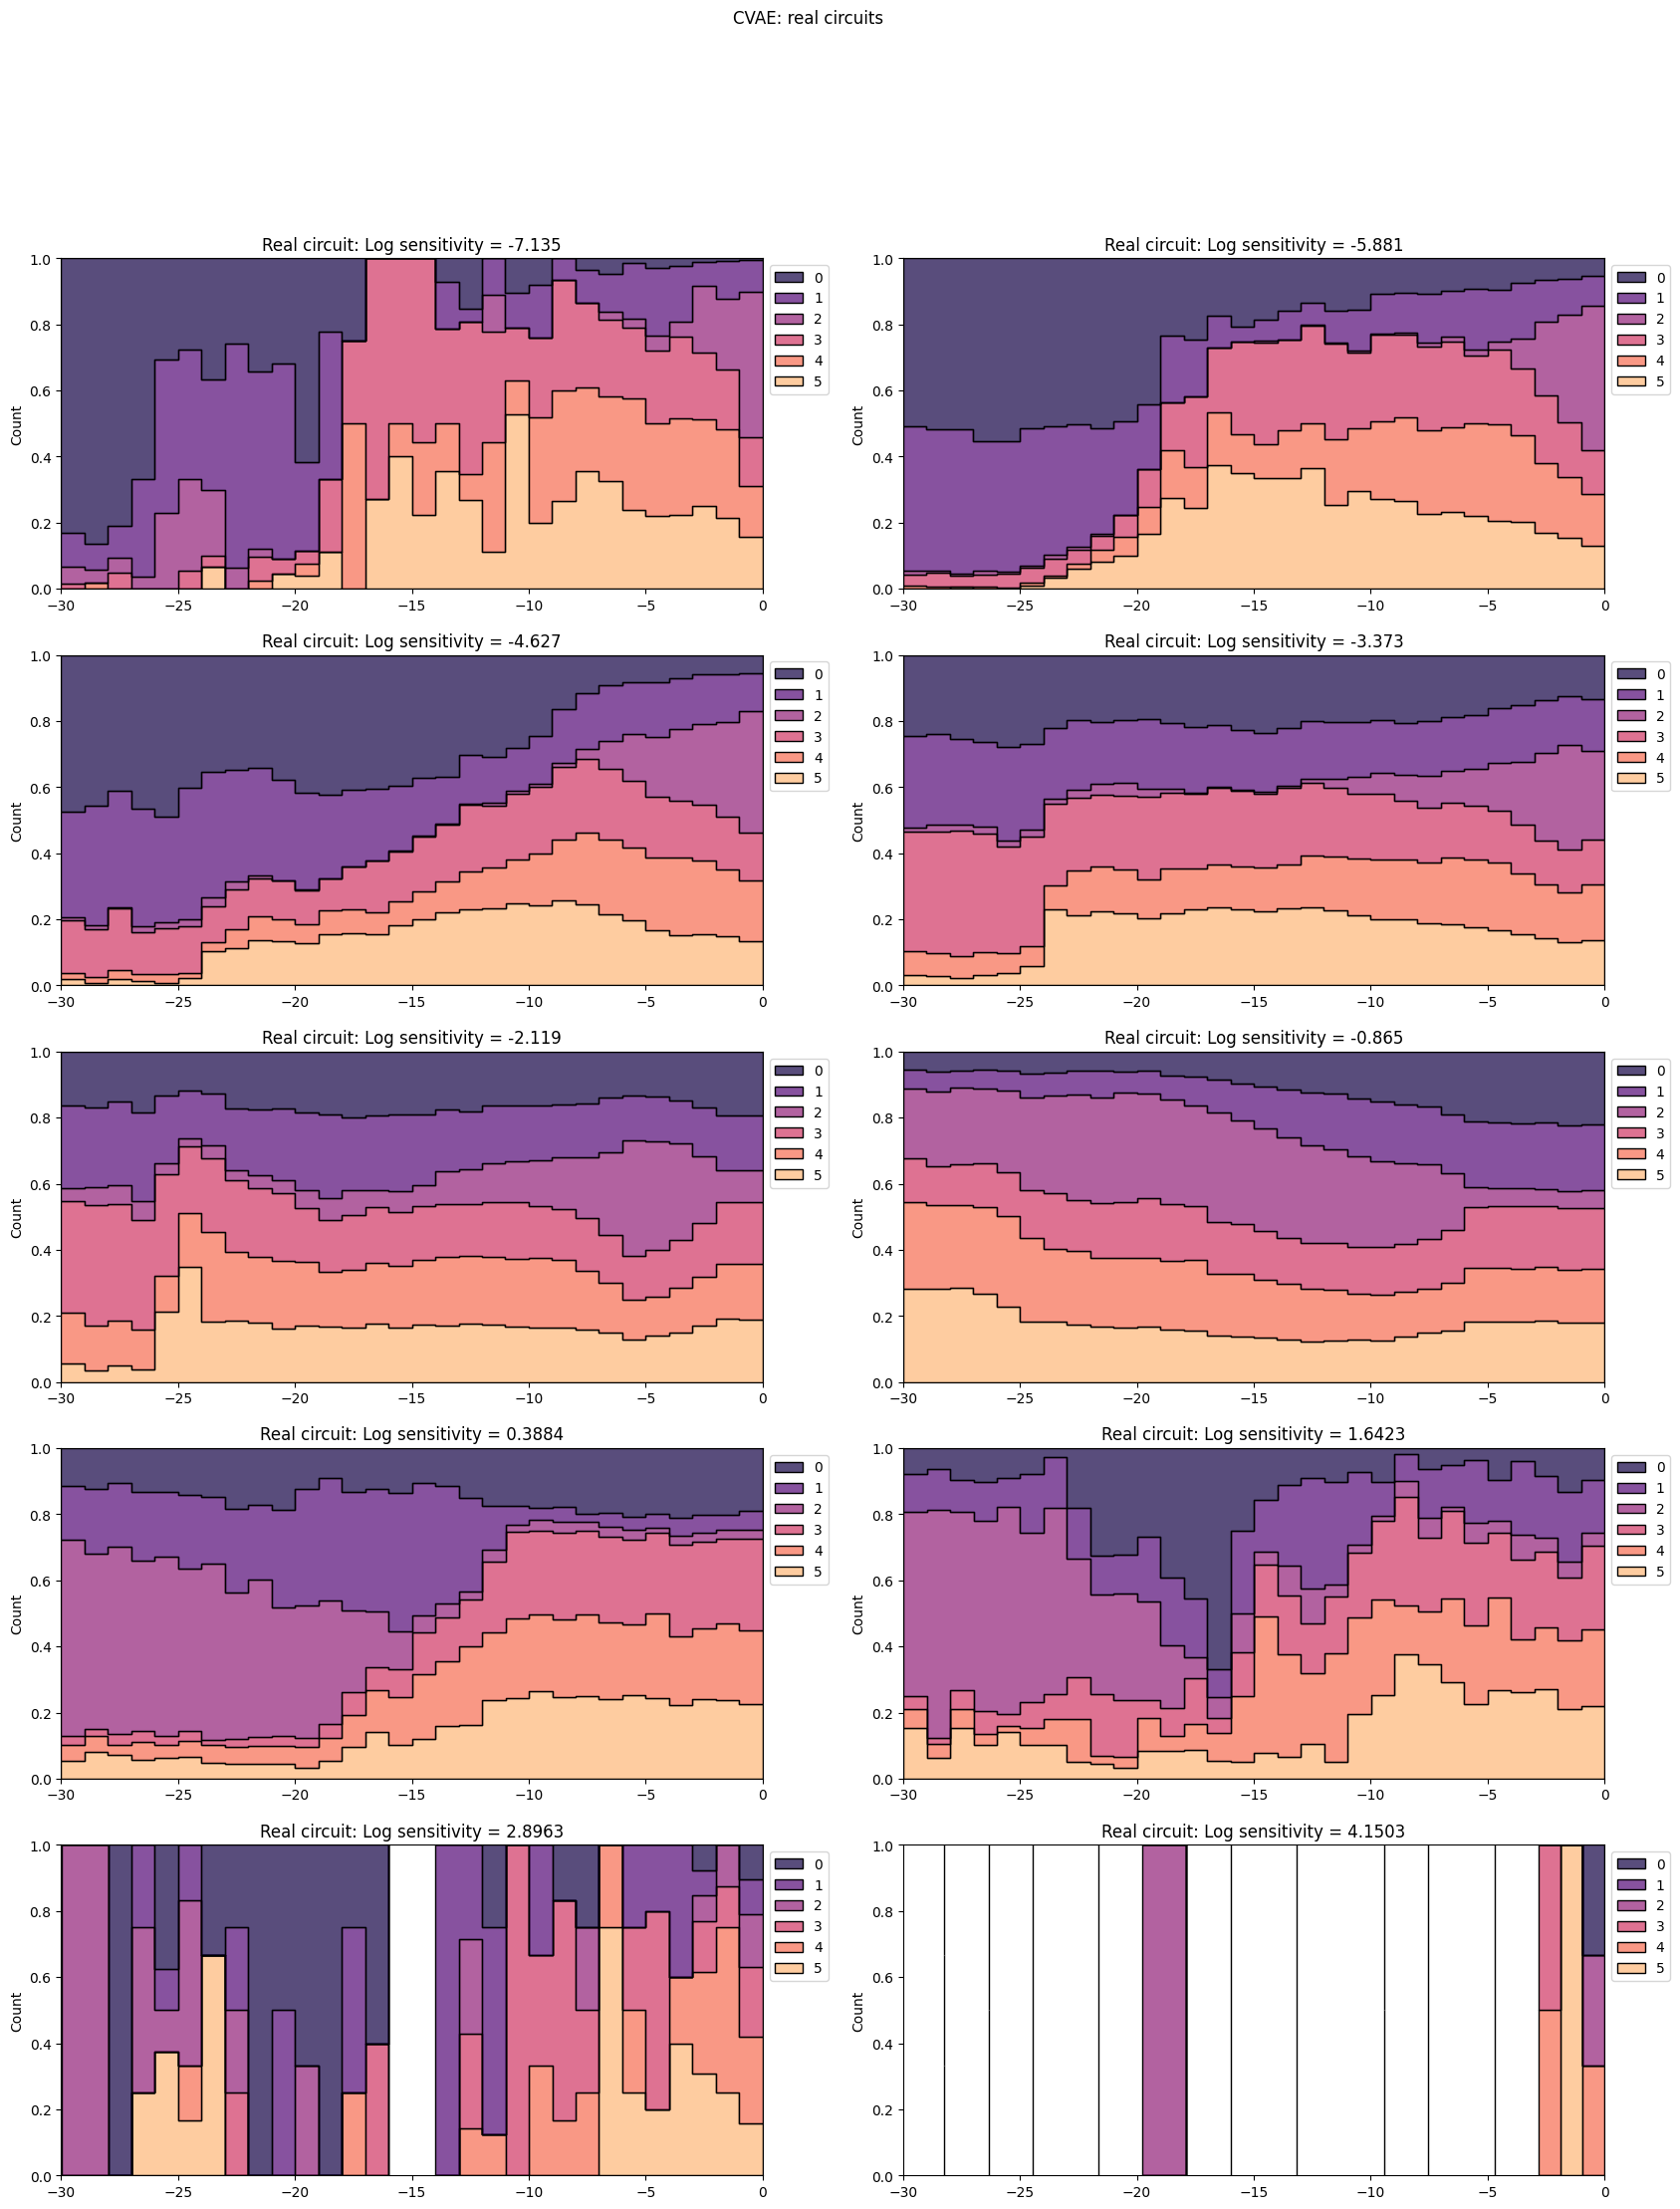

In [50]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

## Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

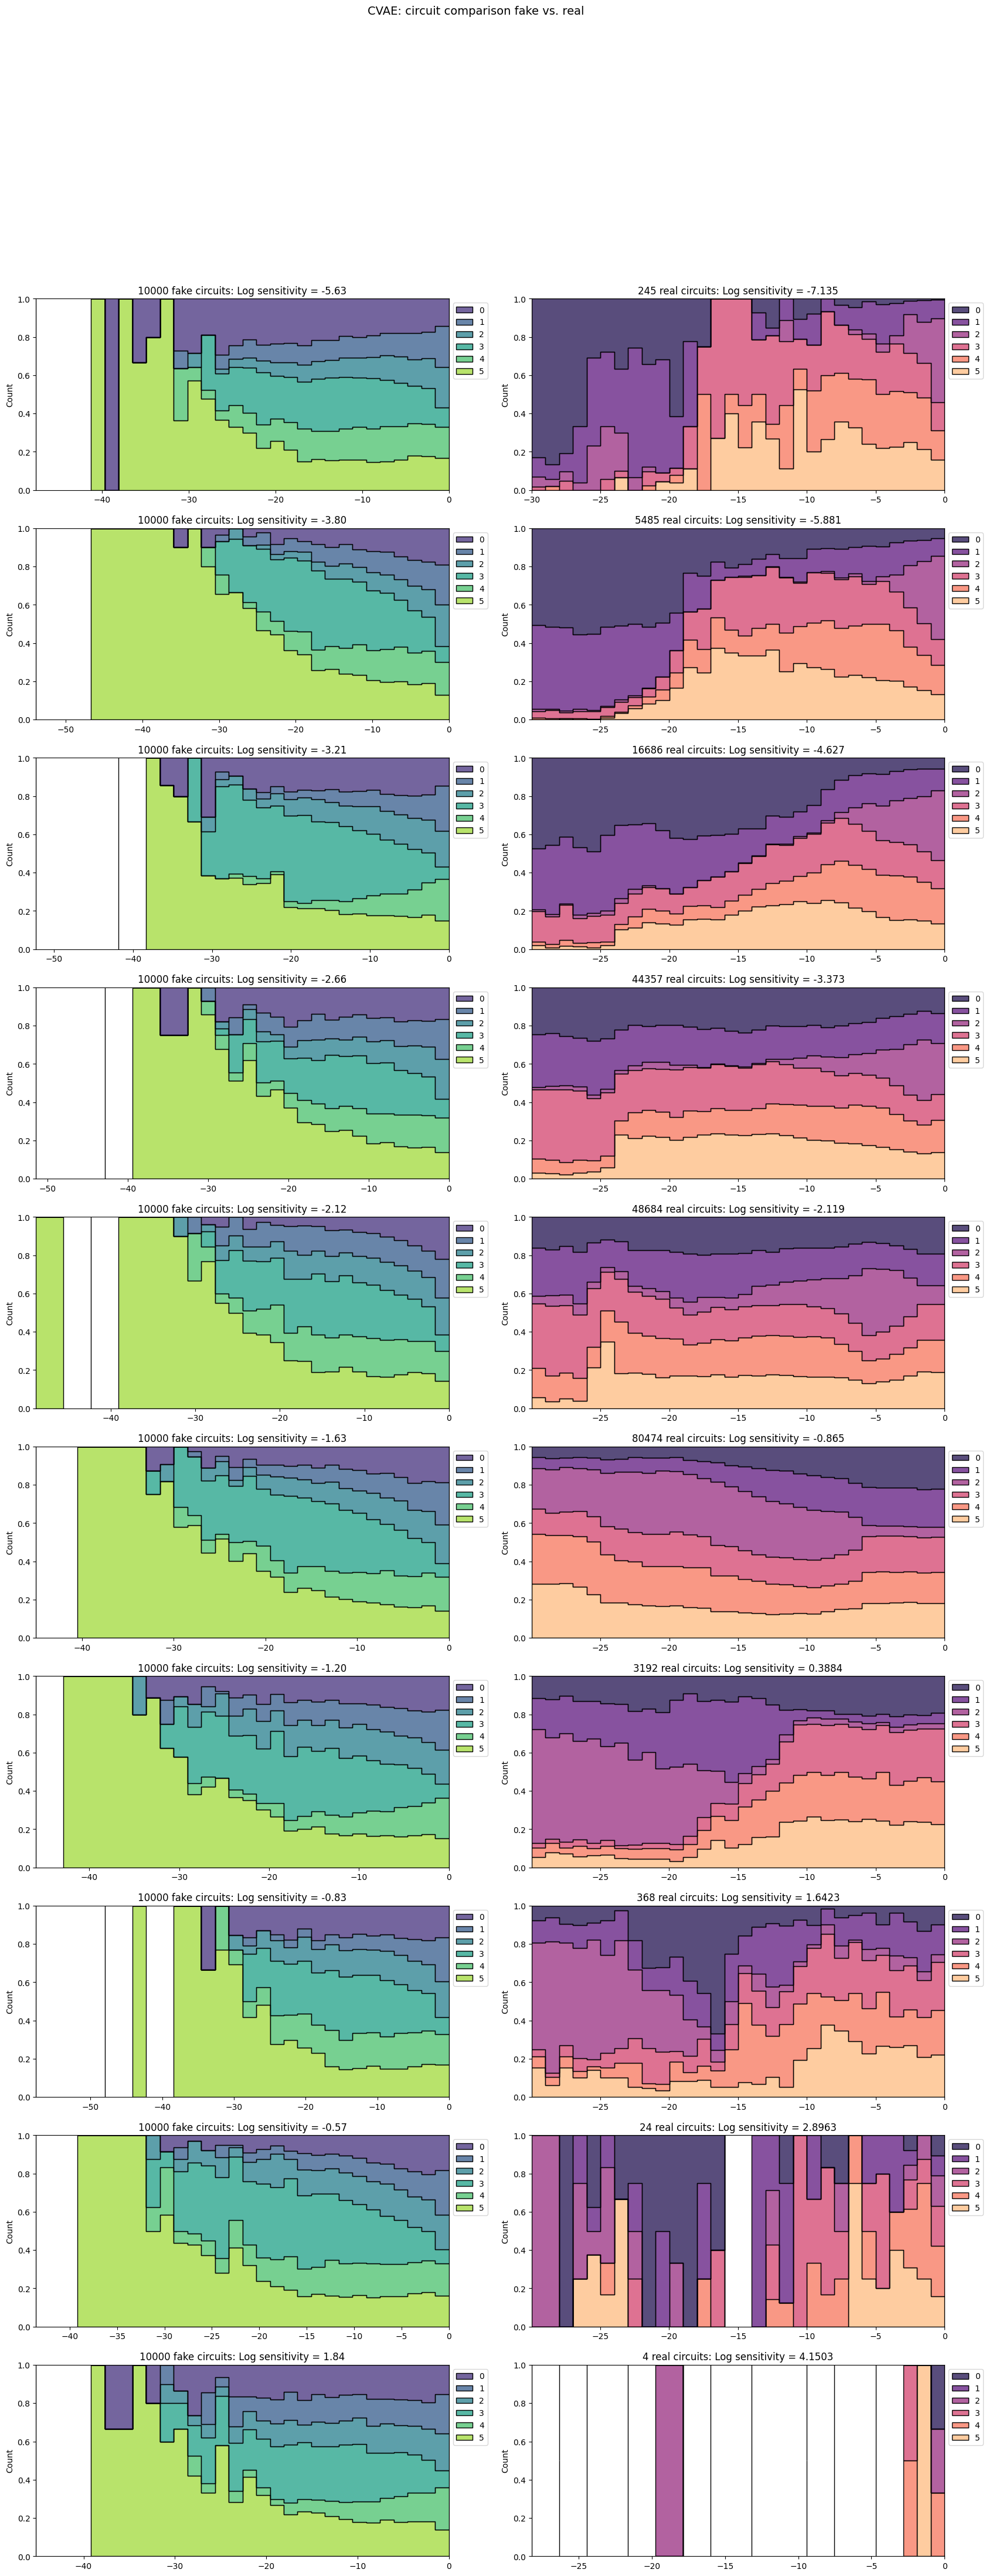

In [51]:
fig = plt.figure(figsize=(10*2, n_categories*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(n_categories, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    # plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(n_categories, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

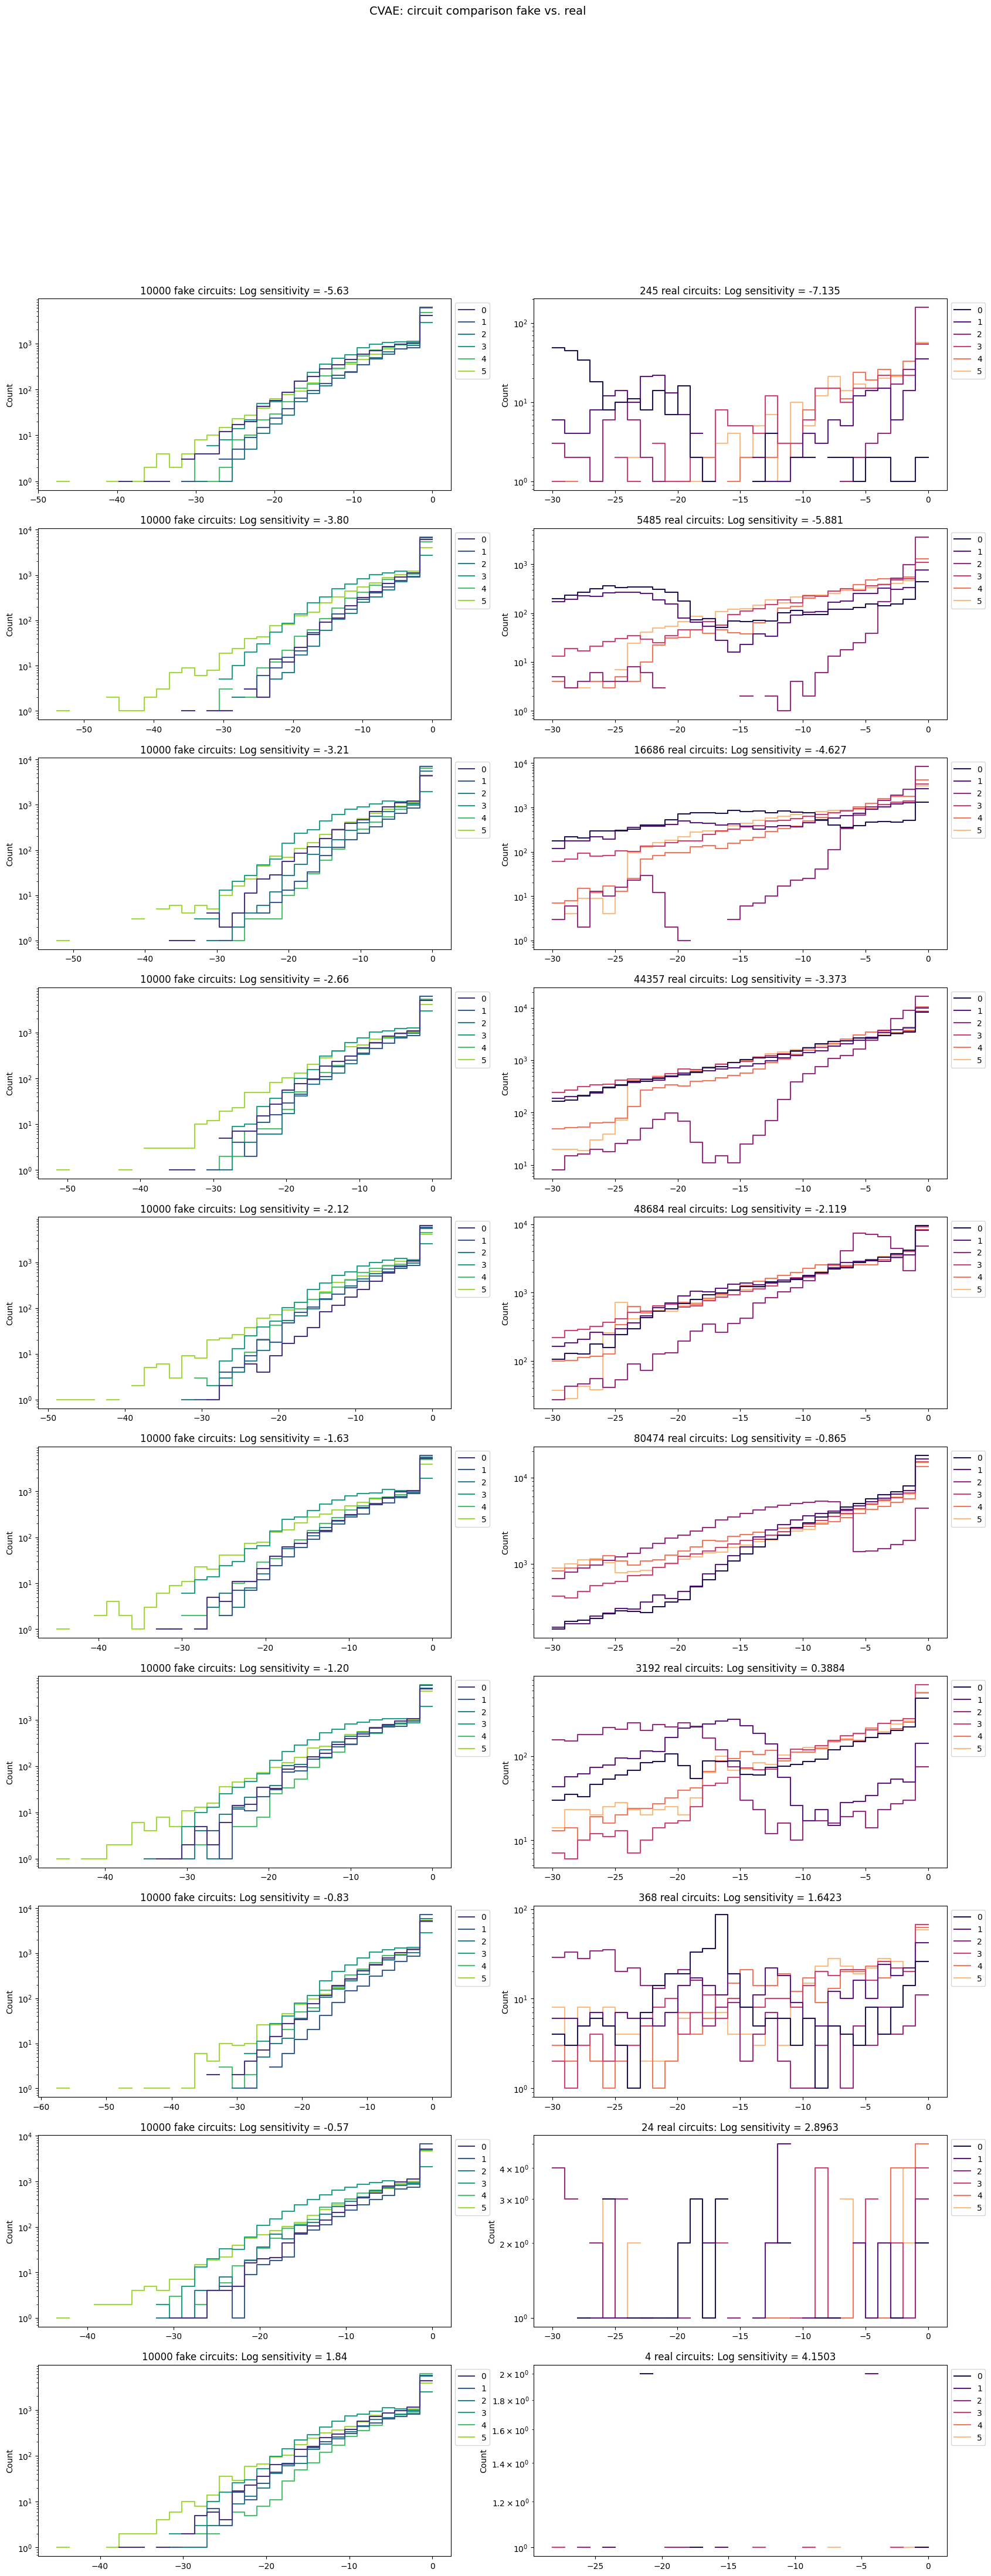

In [52]:
fig = plt.figure(figsize=(10*2, n_categories*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(n_categories, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(n_categories, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)